Must needed setup before every assignment

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


Imports

In [0]:
import itertools
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
#from pyspark.sql.functions import * it overrides abs if we do it like that
import re, sys, pickle
from functools import reduce
import pyspark.sql.functions as F
import matplotlib.pyplot as pl

Setup Spark

In [0]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

Definitions

In [0]:
#Euclidian
def l22(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + b * b, delta, 0)
#Manhattan
def l1(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + abs(b), delta, 0)

def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

Output

In [8]:
#We need to make each and every combination (c1 - l1, c1 -l22, c2 - l1 and c2 - l22)
#I kept same name of variables so for easier commenting and uncommenting
dataFile = 'data.txt'
censFile = 'c1.txt' #we need to comment and uncomment which one we wan't to use
#censFile = 'c2.txt'
distFcn = l1 #Manhattan
distFcn = l22 #Euclidian
outFile = 'dist_' + distFcn.__name__ + '__' + censFile

MAX_ITER = 20 #max iterations
k = 10 #clusters
NDATA = 4601
NDIM = 58
cens = []


# init centroids - py way :D
cens = []
with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

# load data
data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))

phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    # M: calc new centroid
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    # record cost, prep new iter
    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)








iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












623660345.306411
509862908.297545
485480681.872008
463997011.685013
460969266.572997
460537847.982768
460313099.653545
460003523.889408
459570539.317735
459021103.342291
458490656.191981
457944232.587975
457558005.198677
457290136.352302
457050555.059563
456892235.615356
456703630.737034
456404203.018975
456177800.541994
455986871.027347









Plotting the results

Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.18654709691385904
Manhattan c2 0.515540991023891


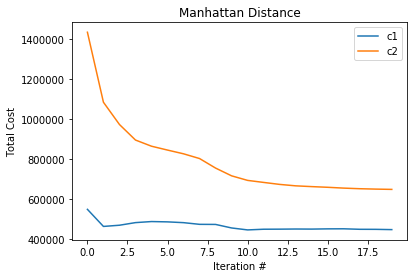

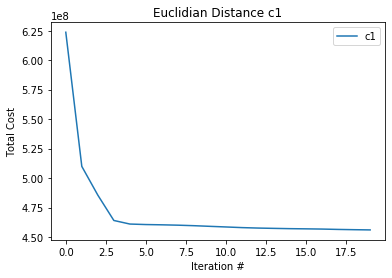

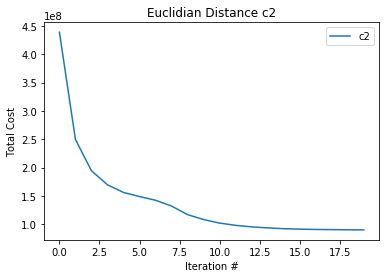

In [5]:
pl.close('all')

with open('dist_l1__c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('dist_l1__c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('dist_l22__c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('dist_l22__c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1')
pl.plot(l1c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300, bbox_inches='tight')

pl.figure()
pl.title("Euclidian Distance c1")
pl.plot(l22c1, label='c1')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC1.png', dpi=300, bbox_inches='tight')
pl.figure()
pl.title("Euclidian Distance c2")
pl.plot(l22c2, label='c2')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidianC2.png', dpi=300, bbox_inches='tight')


def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))